In [1]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-5-nano")

llm.invoke("Hi")

AIMessage(content='Hi there! How can I help today? I can answer questions, explain topics, draft or edit text, brainstorm ideas, plan projects, or code help. What would you like to do? If you’re not sure, tell me your goal and I’ll suggest options.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 256, 'prompt_tokens': 7, 'total_tokens': 263, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D0OSWLkdEUDZgnS3egdP6nhXHKhIj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bdfce-333e-74f2-8efe-f1cebd25db65-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 7, 'output_tokens': 256, 'total_tokens': 263, 'input_token_detail

In [2]:
# Initialize tool calls
from langchain_core.tools import tool
from typing import Literal
from datetime import datetime
from pydantic import BaseModel

@tool
def write_email(to:str, subject:str, thread:str)->str:
    """Write and send email"""
    return f"Email has been send to user : {to}"

@tool
def schedule_meeting(attendies:list[str], subject:str, duration_min:int, preferred_day:datetime, start_time:str)->str:
    """Schedule a calender meeting"""
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
class Done(BaseModel):
    """Email has been send"""
    done:bool
    

In [3]:
tools = [write_email, schedule_meeting, check_calendar_availability, Done]
tools_by_name = {tool.name: tool for tool in tools}

tools_by_name

{'write_email': StructuredTool(name='write_email', description='Write and send email', args_schema=<class 'langchain_core.utils.pydantic.write_email'>, func=<function write_email at 0x10a415e40>),
 'schedule_meeting': StructuredTool(name='schedule_meeting', description='Schedule a calender meeting', args_schema=<class 'langchain_core.utils.pydantic.schedule_meeting'>, func=<function schedule_meeting at 0x10a415f80>),
 'check_calendar_availability': StructuredTool(name='check_calendar_availability', description='Check calendar availability for a given day.', args_schema=<class 'langchain_core.utils.pydantic.check_calendar_availability'>, func=<function check_calendar_availability at 0x10a415ee0>),
 'Done': StructuredTool(name='Done', description='Email has been send', args_schema=<class 'langchain_core.utils.pydantic.Done'>, func=<class '__main__.Done'>)}

In [4]:
## conect too with llm
llm_with_tool = llm.bind_tools(tools, tool_choice="any")


In [5]:
from langgraph.graph import START , END, MessagesState, StateGraph

class State(MessagesState):
    email_input:dict
    classification_decision: Literal["ignore", "notify", "respond"]

In [6]:
from pydantic import BaseModel, Field
class RouterSchema(BaseModel):
    """Analyse the email and route it based on the content"""
    reasoning : str = Field(description="Step by step reasoning behind the classification")
    classification : Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )


In [7]:
    
email_input = {
  "from": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

In [8]:
from email_assistant.template import parse_email
from email_assistant.util_one import user_prompt

sender, receiver, subject , thread = parse_email(email_input)

In [9]:
sender

'Alice Smith <alice.smith@company.com>'

In [10]:
user_prompt.format(sender=sender, to=receiver, subject=subject, thread=thread)

"Please detremine how to handle this email\n\nSender : Alice Smith <alice.smith@company.com>\nReceiver : John Doe <john.doe@company.com>\nSubject : Quick question about API documentation\nThread : Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice\n\n"

In [12]:
from email_assistant.template import parse_email
from email_assistant.util_one import user_prompt
from langgraph.types import Command
llm_with_router = llm.with_structured_output(RouterSchema)

def traige_router(state:State)->Command[Literal["response_agent", "__end__"]]:
    email_input = state["email_input"]
    sender, receiver, subject , thread = parse_email(email_input)
    u_prompt = user_prompt.format(sender=sender, to=receiver, subject=subject, thread=thread)
    response = llm_with_router.invoke(u_prompt)

    if response.classification == "notify":
        goto = END
        update = {
            "classification_decision" : "notify"
        }
    elif response.classification == "ignore":
        goto = END
        update = {
            "classification_decision" : "ignore"
        }
    elif response.classification == "respond":
        goto = "response_agent"
        update = {
            "classification_decision" : "respond",
            "messages" : {
                "role": "user",
                "content": u_prompt
            }
        }
    else:
        raise ValueError("Invalida Value")

    return Command(goto=goto, update=update)

In [13]:
def call_llm(state:State):
    out = state["messages"][-1]
    return llm_with_tool.invoke(out)

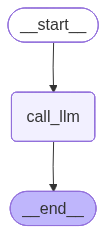

In [14]:
## lets check traige router

router = StateGraph(State)
router.add_node("call_llm", call_llm )
router.add_edge(START, "call_llm")
router.add_edge("call_llm", END)



router = router.compile()

from IPython.display import Image, display


display(Image(router.get_graph(xray=True).draw_mermaid_png()))


In [15]:
workflows = (
    StateGraph(State)
    .add_node("traige", traige_router)
    .add_node("response_agent", router)
    .add_edge(START, "traige")
    # Don't add this edge - traige_router uses Command to control routing
    # .add_edge("traige", "response_agent")
).compile()


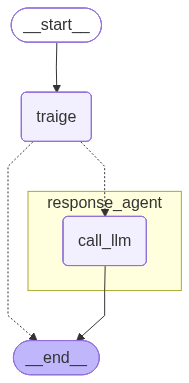

In [19]:
Image(workflows.get_graph(xray=True).draw_mermaid_png())


In [36]:
# Collect all tools
tools = [write_email, schedule_meeting, check_calendar_availability, Done]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM, enforcing tool use
llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="any")

def llm_call(state: State):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            # Invoke the LLM
            llm_with_tools.invoke(
                # Add the system prompt
              state["messages"]
            )
        ]
    }

In [21]:
def tool_handler(state: State):
    """Performs the tool call."""

    # List for tool messages
    result = []
    
    # Iterate through tool calls
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = tools_by_name[tool_call["name"]]
        # Run it
        observation = tool.invoke(tool_call["args"])
        # Create a tool message
        result.append({"role": "tool", "content" : observation, "tool_call_id": tool_call["id"]})
    
    # Add it to our messages
    return {"messages": result}

In [46]:
def should_continue(state: State) -> Literal["tool_handler", "__end__"]:
    """Route to tool handler, or end if Done tool called."""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    print("sam....")
    # Check if it's a Done tool call
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "tool_handler"

In [42]:
from langgraph.graph import StateGraph, START, END

# Build workflow
overall_workflow = StateGraph(State)

# Add nodes
overall_workflow.add_node("llm_call", llm_call)
overall_workflow.add_node("tool_handler", tool_handler)

# Add edges
overall_workflow.add_edge(START, "llm_call")
overall_workflow.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END,
    },
)
overall_workflow.add_edge("tool_handler", "llm_call")

# Compile the agent
agent = overall_workflow.compile()

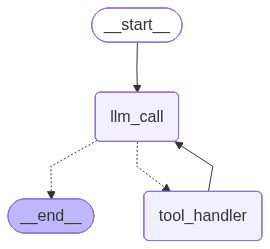

In [43]:
from IPython.display import Image

Image(agent.get_graph().draw_mermaid_png())

In [44]:
overall_workflow = (
    StateGraph(State)
    .add_node("triage_router", traige_router)
    .add_node("response_agent", agent)
    .add_edge(START, "triage_router")
).compile()

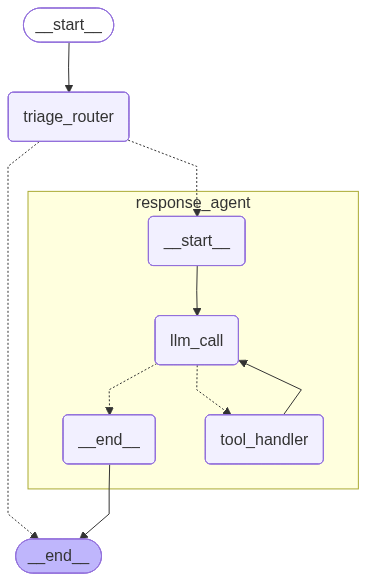

In [32]:
Image(overall_workflow.get_graph(xray=True).draw_mermaid_png())

In [33]:
email_input

{'from': 'Alice Smith <alice.smith@company.com>',
 'to': 'John Doe <john.doe@company.com>',
 'subject': 'Quick question about API documentation',
 'thread': "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"}

In [45]:
overall_workflow.invoke({"email_input": email_input})

sam....
sam....
sam....


{'messages': [HumanMessage(content="Please detremine how to handle this email\n\nSender : Alice Smith <alice.smith@company.com>\nReceiver : John Doe <john.doe@company.com>\nSubject : Quick question about API documentation\nThread : Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice\n\n", additional_kwargs={}, response_metadata={}, id='f9724933-742e-4c63-b5df-8200bc545ed2'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 252, 'total_tokens': 353, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 